<a href="https://www.kaggle.com/code/danuherath/used-car-prices-regression?scriptVersionId=202038527" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center"> Used Car Price Prediction (Regression)</h1>

<img 
    src="https://storage.googleapis.com/kaggle-datasets-images/245550/518395/0117a00b8cd590c31a8b83217458b3ce/dataset-cover.jpg?t=2019-06-25-10-19-42"
    alt="" 
    width="400" 
    height="300" 
    style="display: block; margin: 0 auto; border-radius:15px" 
/>

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from keras.utils import plot_model

RSEED = 42


2.16.1


In [2]:
train_data = pd.read_csv("/kaggle/input/used-cars-price-prediction/train-data.csv")


In [3]:
train_data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
train_data.shape


(6019, 14)

In [5]:
null_cols_sum = train_data.isnull().sum().sort_values(ascending=False)
null_cols_ratio = train_data.isnull().mean().sort_values(ascending=False)

print(null_cols_sum[null_cols_sum > 0])
print(null_cols_ratio[null_cols_ratio > 0])


New_Price    5195
Seats          42
Engine         36
Power          36
Mileage         2
dtype: int64
New_Price    0.863100
Seats        0.006978
Engine       0.005981
Power        0.005981
Mileage      0.000332
dtype: float64


In [6]:
# drop Unnamed: 0 (not useful) and New_Price (too many missing values)
train_data.drop(columns=["Unnamed: 0", "New_Price"], inplace=True)
                         

In [7]:
train_data.nunique()


Name                 1876
Location               11
Year                   22
Kilometers_Driven    3093
Fuel_Type               5
Transmission            2
Owner_Type              4
Mileage               442
Engine                146
Power                 372
Seats                   9
Price                1373
dtype: int64

In [8]:
train_data.dtypes


Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
Price                float64
dtype: object

In [9]:
categorical_features = train_data.select_dtypes(include=["object"]).columns.to_list()
numerical_features = train_data.select_dtypes(exclude=["object"]).columns.to_list()


---
# Data Visualization
---

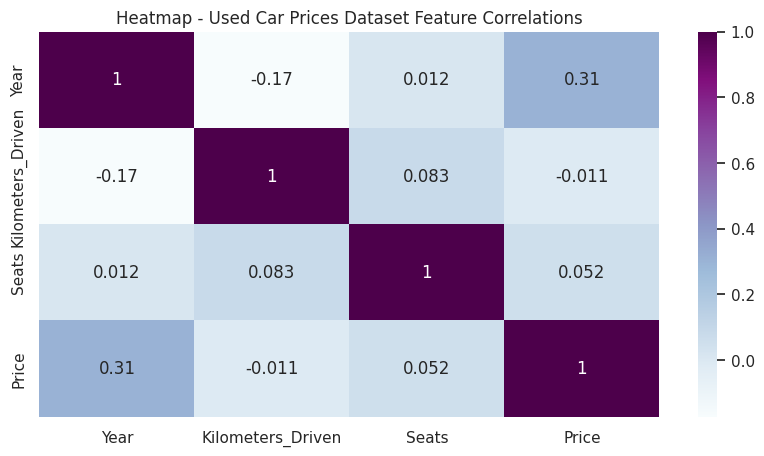

In [10]:
car_prices_corr = train_data[numerical_features].corr()

plt.figure(figsize=(10,5))
sns.heatmap(car_prices_corr, annot=True, cmap="BuPu")
plt.title("Heatmap - Used Car Prices Dataset Feature Correlations")

plt.savefig("Used Car Prices Dataset Feature Correlations.png")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram for target variable (Price)')

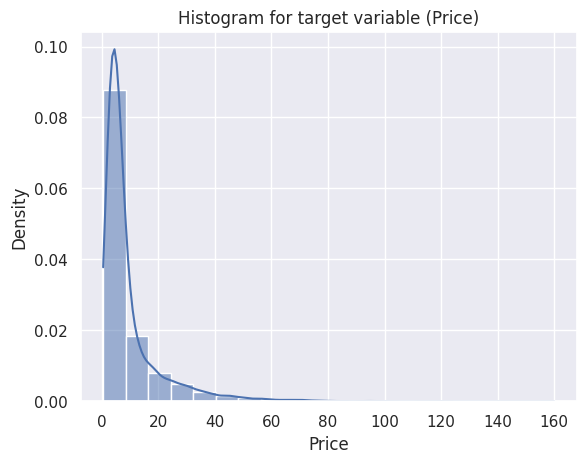

In [11]:
price = train_data["Price"]

sns.histplot(data=price, bins=20, stat="density", kde=True)

plt.title("Histogram for target variable (Price)")


---
# Data Preprocessing
---


In [12]:
# Remove name column (not important)
# print(categorical_features)
categorical_features.remove("Name")
print(categorical_features)


['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power']


In [13]:
train_data[categorical_features].head()

,Location,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power
0,Mumbai,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp
1,Pune,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp
2,Chennai,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp
3,Chennai,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp
4,Coimbatore,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp


In [14]:
train_data[numerical_features].head()

,Year,Kilometers_Driven,Seats,Price
0,2010,72000,5.0,1.75
1,2015,41000,5.0,12.50
2,2011,46000,5.0,4.50
3,2012,87000,7.0,6.00
4,2013,40670,5.0,17.74


In [15]:
cat_data_one_hot_encoded = pd.get_dummies(train_data[categorical_features], drop_first= True)
cat_data_one_hot_encoded.head()


,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,...,Power_97.6 bhp,Power_97.7 bhp,Power_98.59 bhp,Power_98.6 bhp,Power_98.79 bhp,Power_98.82 bhp,Power_98.96 bhp,Power_99 bhp,Power_99.6 bhp,Power_null bhp
0,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
train_data = pd.concat([train_data[numerical_features], cat_data_one_hot_encoded], axis=1)
train_data.head()


,Year,Kilometers_Driven,Seats,Price,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,...,Power_97.6 bhp,Power_97.7 bhp,Power_98.59 bhp,Power_98.6 bhp,Power_98.79 bhp,Power_98.82 bhp,Power_98.96 bhp,Power_99 bhp,Power_99.6 bhp,Power_null bhp
0,2010,72000,5.0,1.75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2015,41000,5.0,12.50,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2011,46000,5.0,4.50,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2012,87000,7.0,6.00,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2013,40670,5.0,17.74,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
missing_cols = train_data.isnull().sum().sort_values(ascending=False)
missing_cols[missing_cols > 0]



Seats    42
dtype: int64

In [18]:
train_data.dropna(inplace=True)


In [19]:
X = train_data.drop(columns=["Price"])
y = train_data["Price"]


In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RSEED)


In [21]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [22]:
input_layer = Input(shape=(X.shape[1],))

dense_layer0 = Dense(100, activation="relu")(input_layer)
dense_layer1 = Dense(50, activation="relu")(dense_layer0)
dense_layer2 = Dense(25, activation="relu")(dense_layer1)
dense_layer3 = Dense(10, activation="relu")(dense_layer2)
dense_layer4 = Dense(5, activation="relu")(dense_layer3)
dense_layer5 = Dense(2, activation="relu")(dense_layer4)
output = Dense(1)(dense_layer5)


In [23]:
model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["mean_absolute_error"])


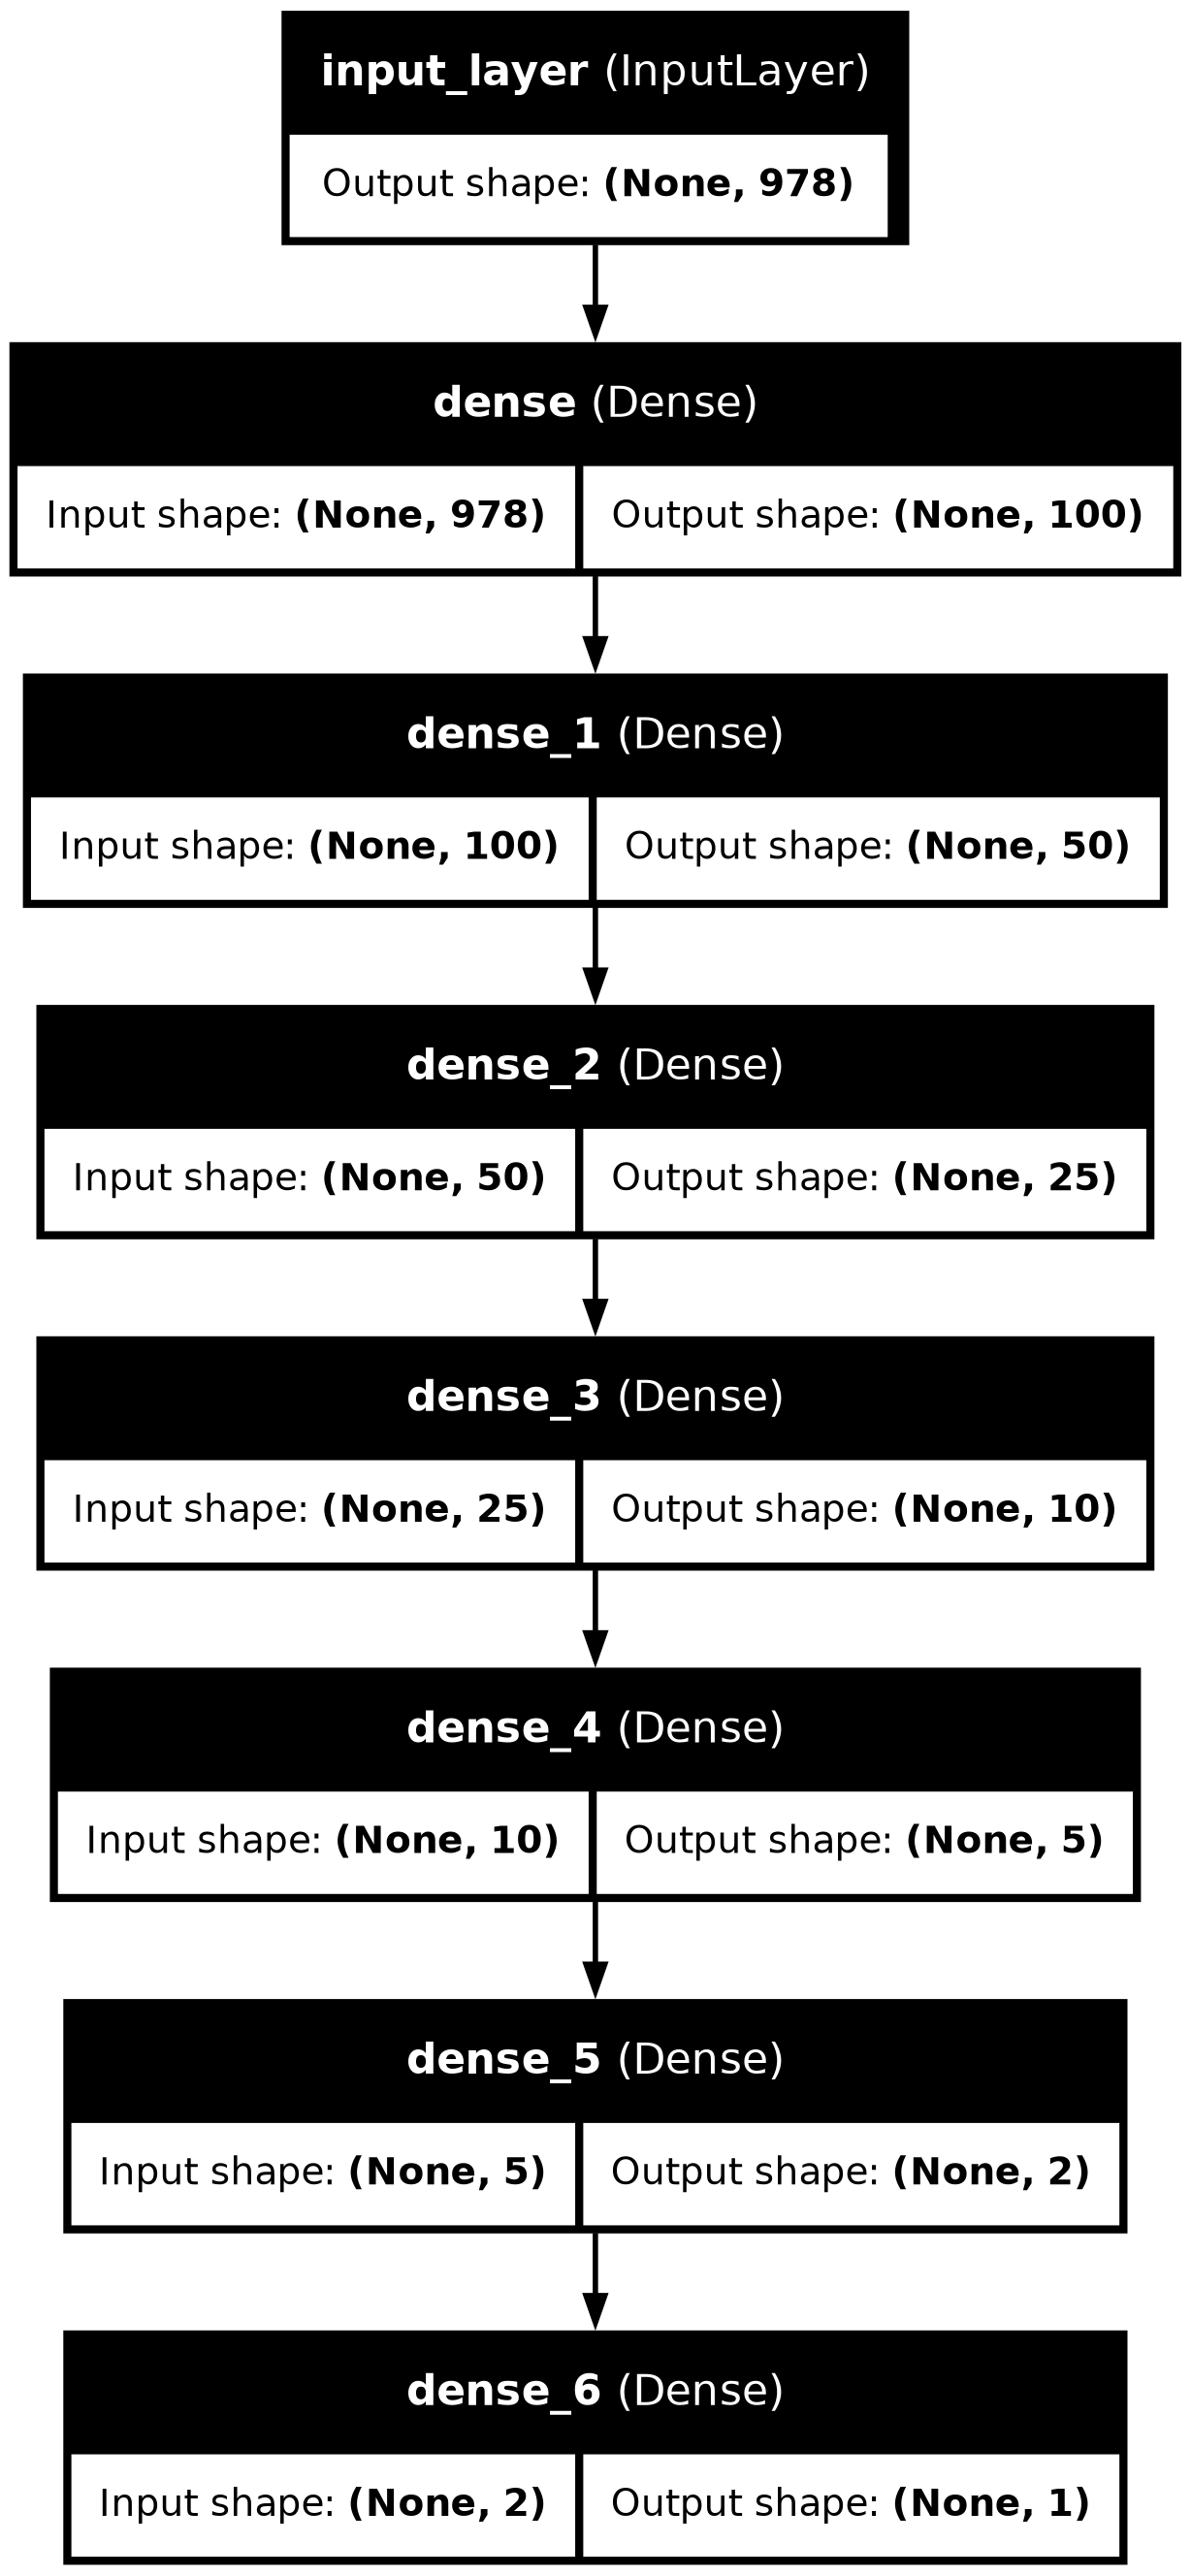

In [24]:

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)


In [25]:
history = model.fit(X_train, y_train, batch_size=5, epochs=5, verbose=1, validation_split=0.2)


Epoch 1/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.1303 - mean_absolute_error: 9.1303 - val_loss: 8.7121 - val_mean_absolute_error: 8.7121
Epoch 2/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.2823 - mean_absolute_error: 8.2823 - val_loss: 7.9989 - val_mean_absolute_error: 7.9989
Epoch 3/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.8797 - mean_absolute_error: 7.8797 - val_loss: 7.3736 - val_mean_absolute_error: 7.3736
Epoch 4/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.0741 - mean_absolute_error: 7.0741 - val_loss: 6.8925 - val_mean_absolute_error: 6.8925
Epoch 5/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.7896 - mean_absolute_error: 6.7896 - val_loss: 6.5589 - val_mean_absolute_error: 6.5589


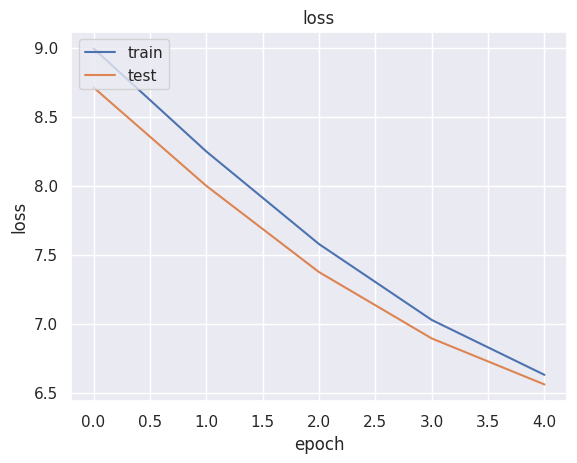

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title("loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [27]:
y_pred = model.predict(X_val)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [28]:
print ("Mean Absolute Error:", metrics.mean_absolute_error(y_val, y_pred))
print ("Mean Squared Error:", metrics.mean_squared_error(y_val, y_pred))
print ("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_val, y_pred)))


Mean Absolute Error: 7.007751010078252
Mean Squared Error: 187.95945500614135
Root Mean Squared Error: 13.709830597280966
